# Note
This notebook is to train the encoder as a classifier with the idea of validate the encoder architecture first and then use this to train the VAE.

# Parameters to experiment

In [1]:
# training on guanaco
# ATENTION: if it is going to run on guanaco:
# 1) comment the %matplotlib magic in next block and any magic (something like %code)
# 2) Change to True the trainingOnGuanaco vairbale
# 3) set epoch with an appropiate number
# 4) add comment to experiemnts
# 5) Add this file as python file 
# 6) Change launchJobOnGuanaco file to run this file but with python format
trainingOnGuanaco = False

# train without notebook
trainWithJustPython = False

# number_experiment (this is just a name)
# priors:
# 1
number_experiment = 27
number_experiment = str(number_experiment)

# seed to generate same datasets
seed = 1

# training
epochs = 100000

# max elements by class
max_elements_per_class = 15000

# train with previous model
trainWithPreviousModel = False

# include delta errors
includeDeltaErrors = True

# band
passband = [0]
# passband = [1]
# passband = [2]
# passband = [3]
# passband = [4]
# passband = [5]
# passband = [0, 1, 2, 3, 4, 5]


# include ohter feautures
includeOtherFeatures = False

# num of features to add
# ṕvar by channel
otherFeaturesDim = 12

In [2]:
# cuda device
cuda_device = 0
cuda_device = "cuda:" + str(cuda_device)

# classes to analyze
# 42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#        95,   6,  53, 994,  64

# periodic
# only_these_labels = [16, 92, 53]

# periodic + variable
only_these_labels = [16, 92, 53, 88, 65, 6]
# 53 has 24 light curves

# only_these_labels = [16, 92]
# only_these_labels = [16, 92]
# only_these_labels = [42,  90,  16,  67,  62, 993,  92,  52,  88,  65, 991, 992,  15,
#         95,   6,  53, 994,  64]

# VAE parameters
latentDim = 100
hiddenDim = 100
inputDim = 72

batch_training_size = 128

# early stopping 
threshold_early_stop = 70

In [3]:
# training params
learning_rate = 1e-3

In [4]:
# add general comment about experiment 
# comment = "encoder as clasifier with periodic + variable (with class balancing) + 1 conv layer more"
comment = "exp " + number_experiment + " + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + " + str(len(passband)) + " channels + seed " + str(seed) + " + " + ("include delta errors" if includeDeltaErrors else "without delta errors") + " + max by class " + str(max_elements_per_class) + " + " + ("" if includeOtherFeatures else "not") + " other features"

print(comment)

exp 27 + encoder as clasifier with periodic + variable + class balancing + 1 conv layer more + 1 channels + seed 1 + include delta errors + max by class 15000 + not other features


# Import libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch.utils import data

# from tqdm import tqdm_notebook

if not trainingOnGuanaco:
    
    %matplotlib notebook
    %load_ext autoreload
    %autoreload 2
else:
    print("not load magics")
    
# import functions to load dataset
import sys
sys.path.append("./codesToDatasets")
from plasticc_dataset_torch import get_plasticc_datasets
from plasticc_plotting import plot_light_curve

import math

from torch import nn

# local imports
# %load_ext autoreload
# %autoreload 2
sys.path.append('../models')
# from classifier import EncoderClassifier, 
from classifierPrototype import EncoderClassifier

sys.path.append("./aux/")
from auxFunctions import *

from sklearn.model_selection import train_test_split

## Load the path to save model while training

In [6]:
import os

# create experiment's folder
tmpGuanaco = "/home/lbravo/thesis/thesis/work/thesis/"
tmpLocal = "/home/leo/Desktop/thesis/work/thesis/"

expPath = "experiments/" + number_experiment + "/seed" + str(seed) + "/maxClass" + str(int(max_elements_per_class/1000)) + "k"

folder_path = (tmpGuanaco + expPath) if trainingOnGuanaco else (tmpLocal + expPath)
# !mkdir folder_path
# os.makedirs(os.path.dirname(folder_path), exist_ok=True)

# check if folder exists
# if not(os.path.isdir(folder_path)):
        
#     # create folder
#     try:
#         os.makedirs(folder_path)
        
#     except OSError as error:
#         print ("Creation of the directory %s failed" % folder_path)
#         print(error)
#     else:
#         print ("Successfully created the directory %s " % folder_path)
# else:
#     print("folder already exists")

# # define paht to save model while training
# pathToSaveModel = (tmpGuanaco + expPath + "/model") if trainingOnGuanaco else (tmpLocal + expPath + "/model")

# Load data

In [7]:
# define path to dataset
pathToFile = "/home/shared/astro/PLAsTiCC/" if trainingOnGuanaco else "/home/leo/Downloads/plasticData/"

## Loading dataset with pytorch tool

In [8]:
# torch_dataset_lazy = get_plasticc_datasets(pathToFile)

# Light curves are tensors are now [bands, [mjd, flux, err, mask],
# lc_data, lc_label, lc_plasticc_id                              
torch_dataset_lazy = get_plasticc_datasets(pathToFile, only_these_labels=only_these_labels, max_elements_per_class = max_elements_per_class)

You have selected lazy loading. Light curves will be loaded ondemand from the harddrive
Found 2 csv files at given path
Loading /home/leo/Downloads/plasticData/plasticc_train_lightcurves.csv
Loading /home/leo/Downloads/plasticData/plasticc_test_set_batch1.csv


In [9]:
assert torch_dataset_lazy.__len__() != 494096, "dataset should be smaller"
print("dataset test ok")

dataset test ok


# plot light curve

In [10]:
# lc_data, label, lc_id = torch_dataset_lazy.__getitem__(1300)

# # 11 was good

# fig, ax = plt.subplots(figsize= (8,6), tight_layout=True)
# for band, band_name in enumerate('ugrizY'):
#     mask = lc_data[band, 3, :] == 1
#     mjd, flux, flux_err = lc_data[band, :3, mask]
#     ax.errorbar(mjd, flux, flux_err, fmt='.', label=band_name)
# ax.legend()
# ax.set_ylabel('Flux', fontsize = 20)
# ax.set_xlabel('Modified Julian Data', fontsize = 20)
# ax.set_title(f'PLAsTiCC ID: {lc_id} Label: {label}', fontsize = 20)

In [11]:
# fig.savefig("lightCurve.pdf", bbox_inches='tight')

# Spliting data (train/test)

In [12]:
def getDataInformation(dataset):
    
    totalSize = dataset.__len__()
    
    print("total light curves: ", totalSize)
#     ids = np.zeros(shape = (totalSize,))
#     targets = np.zeros(shape = (totalSize,))
    
    # samples by filter
    samplesByFilter = np.zeros(shape = (totalSize, 6))
    
    # time length mean
    timeLength = np.zeros(shape = (totalSize, 6))
    
    # mean error
    errorMeanByFilter = np.zeros(shape = (totalSize, 6))
    
    # flux 
    fluxMeanByFilter = np.zeros(shape = (totalSize, 6))
    fluxStdByFilter = np.zeros(shape = (totalSize, 6))
    
    # delta time mean
    deltaTimeMean = np.zeros(shape= (totalSize, 6))
    
    targets = np.zeros(shape = (totalSize, 6))
    
    # to filter after
    arrays = [samplesByFilter, timeLength, errorMeanByFilter, fluxMeanByFilter, fluxStdByFilter, deltaTimeMean, targets]
    
    for idx, data_ in enumerate(dataset):
        
#         print(data[0][0, 2, :])
        
        data = data_[0]
        
        # get samples by filter
        samplesByFilter[idx, :] = torch.count_nonzero(data[:, 3, :], dim = 1)
        
        # get targets
        targets[idx, :] = data_[1]
        
        # iterating by each filter
        for i in range(6):
            
#             data = data_[0]
            
            # taking last valid index
            # mask= [1,1,1,1,1, 0,0,0,0]
            # so it is taking the last non zero -1 (last item index)
            lastIndex = samplesByFilter[idx, i].astype(int)-1
            
            # test
#             assert data[0][i, 3, lastIndex] == 1 and data[0][i, 3, lastIndex+1] == 1
            
            # diff between last and first time
            timeLength[idx, i] = data[i, 0, lastIndex]  - data[i, 0, 0]
            
            # mean error
#             print(torch.mean(data[0][i, 2, 0:lastIndex], dim = 0).shape)
            errorMeanByFilter[idx, i] = torch.mean(data[i, 2, 0:lastIndex], dim = 0)
            
            # flux mean
            fluxMeanByFilter[idx, i] = torch.mean(data[i, 1, 0:lastIndex], dim = 0)
#             unbiased = True give nan for channle 0
            fluxStdByFilter[idx, i] = torch.std(data[i, 1, 0:lastIndex], dim = 0)
            
        
            # delta time
            originalTime = data[i, 0, 0:lastIndex]
#             print(originalTime.shape)
#             if originalTime.shape > :
        
            deltaTimeMean[idx, i] = torch.mean(originalTime[1:] - originalTime[:-1], dim = 0)
    
# #             if np.isnan(deltaTimeMean[idx, i]):
#             if np.isnan(fluxStdByFilter[idx, i]):
#                 print("nan value")
#                 print(lastIndex)
#                 print(originalTime)
#                 print(torch.mean(originalTime[1:] - originalTime[:-1], dim = 0))
#                 print(fluxMeanByFilter[idx, i])
#                 print(data[i, 1, 0:lastIndex])
#             print(deltaTimeMean[idx, i])
        
#     applyMask = False
    
    # remove nan values
#     for idx, array in enumerate(arrays):
            
#         if np.any(np.isnan(array)):
            
            
    mask = ~np.isnan(fluxStdByFilter).any(axis = 1)
    for idx, array in enumerate(arrays):
            
        arrays[idx] = array[mask, :]
            
#         if np.any(np.isnan(array)):
            
#         array = array[mask, :]
#         arrays[idx] = array
    
    
#             print(tmpDeltaTime)
# #     print(samplesByFilter.mean(dim = 0))
#     print(timeLength.shape)
#     print(errorByFilter)
    
#     return samplesByFilter, timeLength, errorMeanByFilter, fluxMeanByFilter, fluxStdByFilter,deltaTimeMean
    return arrays

In [13]:
samplesByFilter, timeLength, errorMeanByFilter, fluxMeanByFilter, fluxStdByFilter, deltaTimeMean, targets = getDataInformation(torch_dataset_lazy)

total light curves:  3276


In [60]:
targets_ = np.unique(targets)

In [15]:
def getStats(arrays, targets):
    
    arrayNames = ["samples", "time length", "error mean by filter", "flux mean by filter", "flux Std By Filter", "delta Time Mean"]
    
    targets_ = np.unique(targets)
    
    statsMeans = np.zeros(shape = (len(arrayNames), targets_.shape[0], 6) )
    
    statsStd = np.zeros(shape = (len(arrayNames), targets_.shape[0], 6) )
    
    
    for idx, array in enumerate(arrays):
            
        print(arrayNames[idx] + "\n")
        
        for idxClass, class_ in enumerate(targets_):

            print(class_)
            
    #         print(targets.shape)
            maskClass = (targets[:, 0] == class_)
            
#             print(array[maskClass,:].shape[0])
            print(arrayNames[idx])
            print(np.mean(array[maskClass,:], 0))
            print(np.std(array[maskClass,:], 0))
            print("\n\n")
            
            
            statsMeans[idx, idxClass, :] = np.mean(array[maskClass,:], 0)
            statsStd[idx, idxClass, :] = np.std(array[maskClass,:], 0)
            
#             dict_[arrayNames[idx]][targets[0, 0]]["mean"] =  np.mean(array[maskClass,:], 0)
#             tmpDict[targets_] = np.mean(array[maskClass,:], 0)
#             print(np.mean(array[maskClass,:], 0))
#             dict_[arrayNames[idx]][targets_]=  np.mean(array[maskClass,:], 0)

#         print(tmpDict)
    
    return statsMeans, statsStd

In [16]:
statsMeans, statsStd = getStats([samplesByFilter, timeLength, errorMeanByFilter, fluxMeanByFilter, fluxStdByFilter, deltaTimeMean], targets)

samples

6.0
samples
[15.8089172  14.43312102 24.12738854 22.99363057 32.         35.50318471]
[14.14940018 12.4600119   9.87419342 10.23948696  8.36431608 10.34908175]



16.0
samples
[19.6429342  18.24271845 26.71305286 25.99568501 33.1639698  36.46494067]
[18.55359917 16.12707053 12.35704325 12.85459227 10.21954663 10.89097736]



53.0
samples
[23.38888889 22.22222222 29.         28.47222222 35.11111111 39.        ]
[21.65932924 18.11707468 14.18723996 14.4865572  10.68950102 10.24966124]



65.0
samples
[28.7840691  26.11516315 33.04318618 32.40978887 37.45201536 39.86948177]
[24.38062727 20.40309196 15.46654667 15.96276919 12.4560687  11.75078098]



88.0
samples
[43.71311475 38.85655738 42.6420765  42.46994536 44.71584699 45.76502732]
[26.32981631 20.58077312 15.53421326 15.79990743 12.69422313 11.36200075]



92.0
samples
[36.0839895  33.14173228 38.17585302 37.68766404 41.73490814 43.80839895]
[26.17633081 21.61390789 16.51208242 17.03307205 13.10789325 12.15462639]



time len

In [84]:
def getErrorComplicated(err, flux, targets):
    
#     print(np.median(err, 0))
# #     print(np.std(flux, 0))
    
#     stats = np.zeros(shape = (2, 6))
    
#     stats[0, :] = np.median(err, 0)/np.std(flux, 0)
# #     
# #     print("error normalizado promedio")
# #     print(np.median(err, 0)/np.std(flux, 0))
# #     print("\n")
    
#     stats[1, :] = np.std(err,0)/np.std(flux,0)
    
# #     print("errores fotométricos normalizados")
# #     print(np.std(err,0)/np.std(flux,0))
    
#     return stats



    targets_ = np.unique(targets)
    
#     statsMeans = np.zeros(shape = (len(arrayNames), targets_.shape[0], 6) )
    stats = np.zeros(shape = (2, 6, 6))
    
    
    for idxClass, class_ in enumerate(targets_):

        print(class_)

#         print(targets.shape)
        maskClass = (targets[:, 0] == class_)

#             print(array[maskClass,:].shape[0])
#         print(arrayNames[idx])
#         print(np.mean(array[maskClass,:], 0))
#         print(np.std(array[maskClass,:], 0))
#         print("\n\n")

    
#         print("error normalizado promedio")
#         print(np.median(err, 0)/np.std(flux, 0))
#         print("\n")

        stats[0, idxClass, :] = np.median(err[maskClass, :], 0)/np.std(flux[maskClass, :], 0)
        
        
#         print("errores fotométricos normalizados")
#         print(np.std(err,0)/np.std(flux,0))

        stats[1, idxClass, :] = np.std(err[maskClass, :],0)/np.std(flux[maskClass, :],0)
    

#             dict_[arrayNames[idx]][targets[0, 0]]["mean"] =  np.mean(array[maskClass,:], 0)
#             tmpDict[targets_] = np.mean(array[maskClass,:], 0)
#             print(np.mean(array[maskClass,:], 0))
#             dict_[arrayNames[idx]][targets_]=  np.mean(array[maskClass,:], 0)

#         print(tmpDict)
    
    return stats

In [86]:
errorStats = getErrorComplicated(errorMeanByFilter, fluxMeanByFilter, targets)

6.0
16.0
53.0
65.0
88.0
92.0


In [92]:
# errorStats[0, :, :]

In [94]:
results = {"stats": {"means": statsMeans, "std": statsStd}, "errorStats": errorStats}

# # save stats
a_file = open("./datasetStats.pkl", "wb")
pickle.dump(results, a_file)
a_file.close()

In [95]:
import sys


sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")

SystemExit: Exit from code, because we are in cluster or running locally. Training has finished.

/home/leo/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3426: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [75]:
# # # load ids dictionary
# a_file = open("./datasetStats.pkl", "rb")
# output = pickle.load(a_file)
# print(output["stats"]["means"].shape)

(6, 6, 6)


<IPython.core.display.Javascript object>


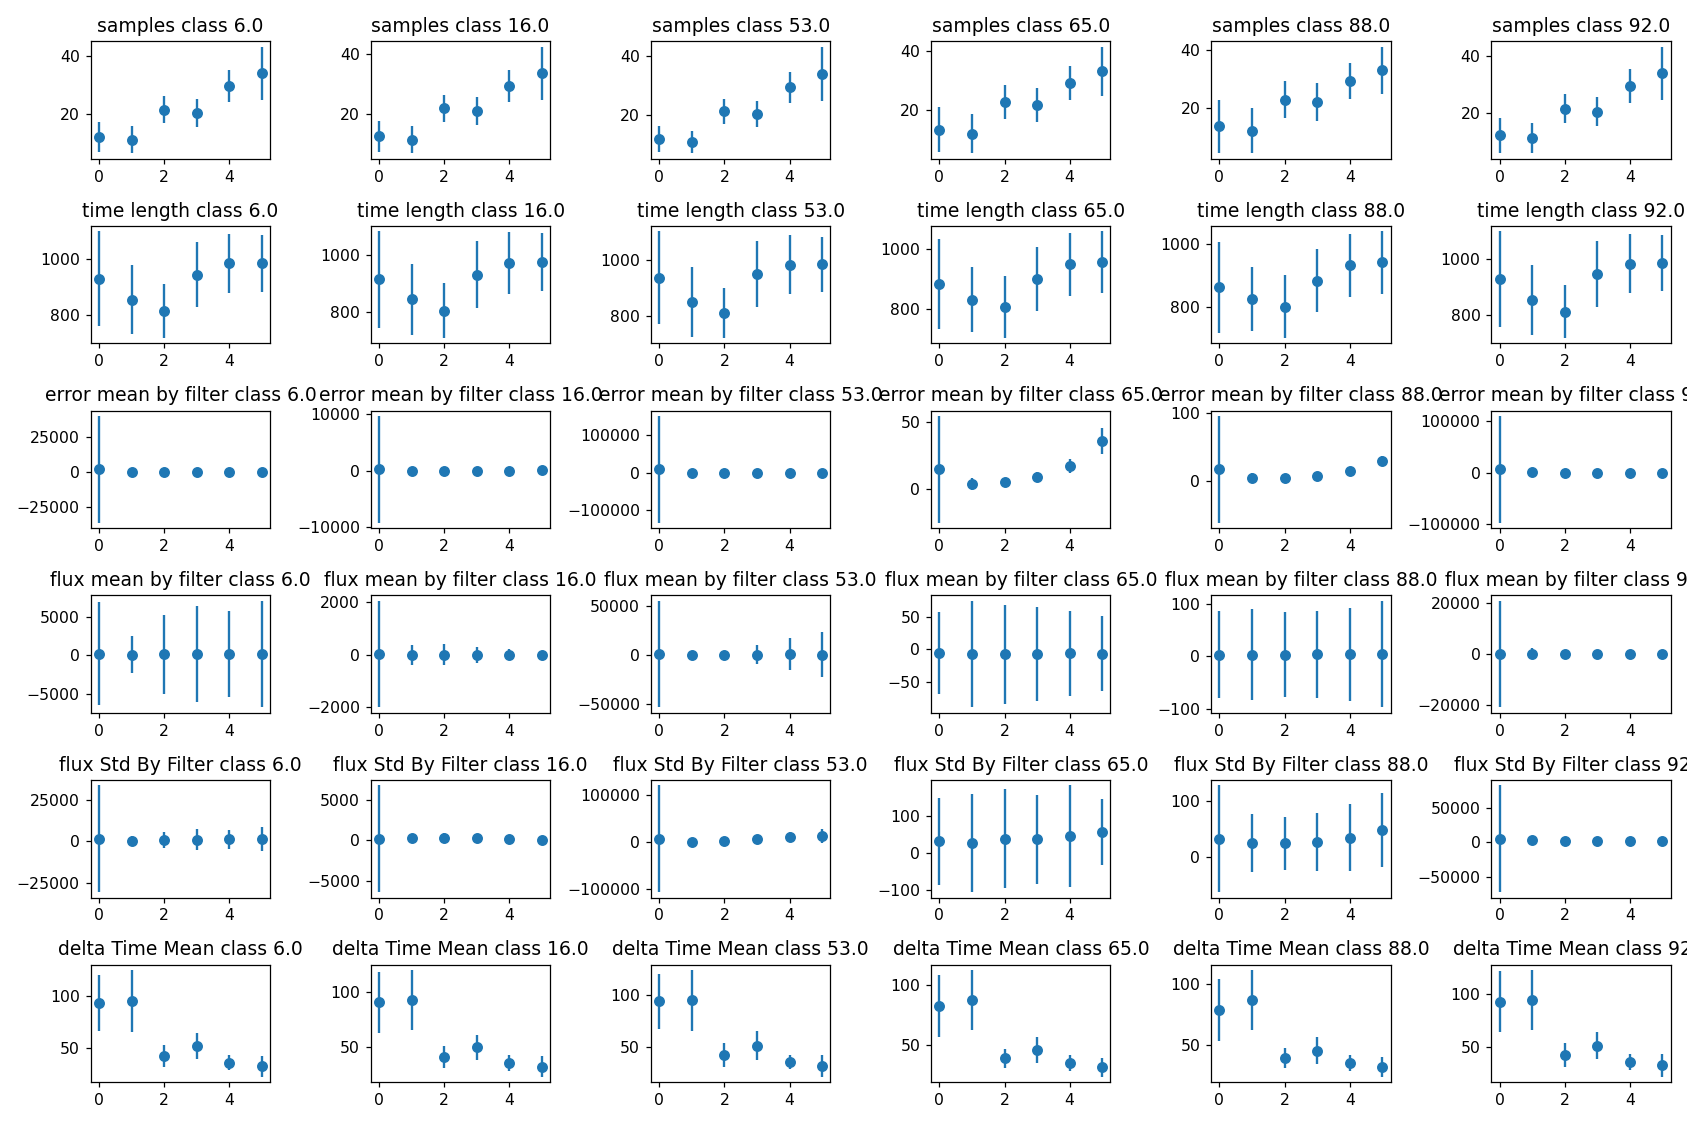

In [63]:
# plot

# fig, ax = plt.subplots()

arrayNames = ["samples", "time length", "error mean by filter", "flux mean by filter", "flux Std By Filter", "delta Time Mean"]

fig, ax = plt.subplots(len(arrayNames), 6, tight_layout = True, figsize = (15,10))

for i in np.arange(len(arrayNames)):
    
    for c in np.arange(6):
        
        ax[i, c].errorbar(np.arange(0, 6), output["stats"]["means"][i, c, :], yerr=output["stats"]["std"][i, c, :], fmt='o')
        ax[i, c].set_title(arrayNames[i] + " class " + str(targets_[c]))

In [64]:
arrayNames = ["error normalizado promedio", "errores fotométricos normalizados"]

fig, ax = plt.subplots(len(arrayNames), 6, tight_layout = True, figsize = (15,10))

for i in np.arange(len(arrayNames)):
    
    for c in np.arange(6):
        
        ax[i, c].scatter(np.arange(0, 6), output["errorStats"]["means"][i, c], yerr=output["errorStats"]["std"][i, c, :], fmt='o')
#         ax[i, c].errorbar(np.arange(0, 6), output["errorStats"]["means"][i, c], yerr=output["errorStats"]["std"][i, c, :], fmt='o')
        ax[i, c].set_title(arrayNames[i] + " class " + str(targets_[c]))

<IPython.core.display.Javascript object>

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [21]:
# splitting the data

# get light curves ids, targets
# ids, targets, lightCurvesIds = getLightCurvesIds(torch_dataset_lazy)


# test array shapes
# assert len(targets) == torch_dataset_lazy.__len__()
# print(ids, len(ids), targets, len(targets))
# get light curves targets
# print("# light curves ids: " + str(len(ids)))

# # split training
# trainIdx, tmpIdx = train_test_split(
#     ids,
#     test_size = 0.2,
#     shuffle = True,
#     stratify = targets,
#     random_state = seed
# )

# # float to int
# tmpIdx = tmpIdx.astype(int)

# # split val, test
# valIdx, testIdx = train_test_split(
#     tmpIdx,
# #     targets,
#     test_size = 0.5,
#     shuffle = True,
#     stratify = targets[tmpIdx],
#     random_state = seed
# )

# # float to int
# trainIdx = trainIdx.astype(int)
# valIdx = valIdx.astype(int)
# testIdx = testIdx.astype(int)

In [ ]:
# saving ids
# saveLightCurvesIdsBeforeBalancing(trainIdx, valIdx, testIdx, folder_path, lightCurvesIds, targets)

In [ ]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_before_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output)

In [ ]:
# # # analize classes distributino
# fig, ax = plt.subplots(3, 1)

# ax[0].hist(targets[trainIdx])
# ax[1].hist(targets[valIdx])
# ax[2].hist(targets[testIdx])

In [ ]:
# # Spliting the data

# # print(torch_dataset_lazy.__len__())

totalSize = torch_dataset_lazy.__len__()

# totalSize = totalSize
# # print(totalSize)

# selecting train splitting
# train_size = int(0.8 * totalSize)
train_size = trainIdx.shape[0]
#print(train_size)

# # getting test splitting
# validation_size = math.floor((totalSize - train_size)/3)
validation_size = valIdx.shape[0]
# #print(validation_size)

# # getting test splitting
# test_size = totalSize - train_size - validation_size
test_size = testIdx.shape[0]
# #print(test_size)

# # spliting the torch dataset
# trainDataset, validationDataset,  testDataset = torch.utils.data.random_split(
#     torch_dataset_lazy, 
#     [train_size, validation_size, test_size],
    
#     # set seed
#     generator = torch.Generator().manual_seed(seed)
# )

print("train size:", train_size)
print("validation size: ", validation_size)
print("test size:", test_size)
totTmp = train_size+ validation_size + test_size
print("sum: ", totTmp)
assert torch_dataset_lazy.__len__() == totTmp, "dataset partition should be the same"

## Create a dataloader

In [ ]:
print("initila distribution")
# initialClassesDistribution = countClasses(trainDataset, only_these_labels)
initialClassesDistribution = np.unique(targets, return_counts=True)[1]

print(initialClassesDistribution)

# fig, ax = plt.subplots()
# ax.bar(x = np.arange(len(only_these_labels)), height = initialClassesDistribution)

In [ ]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    torch_dataset_lazy, 
    batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(
        torch_dataset_lazy, 
        indices = trainIdx,
        seed = seed
#         indices = [0, 1, 2]
    ),
#     sampler = torch.utils.data.SubsetRandomSampler(
#         trainIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
    # each worker retrieve data from disk, so the data will be ready to be processed by main process. The main process should get the data from disk, so if workers > 0, the workers will get the data (not the main process)
    num_workers = 4,
    
    # https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
    # the dataloader loads the data in pinned memory (instead of pageable memory), avoiding one process (to transfer data from pageable memory to pinned memory, work done by CUDA driver)
    pin_memory = True,
)


# validation loader
validationLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
    batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = valIdx,
#     sampler = torch.utils.data.SubsetRandomSampler(
#         valIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
#     sampler=ImbalancedDatasetSampler(
#         torch_dataset_lazy, 
#         indices = valIdx,
#         seed = seed
# #         indices = [0, 1, 2]
#     ),
)

# # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
testLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = testIdx,
#     sampler = torch.utils.data.SubsetRandomSampler(
#         testIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
)

In [ ]:
print("balanced distribution")
balancedClassesDistribution = countClasses(trainLoader, only_these_labels)

print(balancedClassesDistribution)
# fig, ax = plt.subplots()
# ax.bar(x = np.ar# return 0# return 0ange(6), height = balancedClassesDistribution)
# ax.bar(x = only_these_labels, height = temp2, width = 10)

In [ ]:
# save ids of dataset to use (train, test and validation)
saveLightCurvesIdsAfterBalancing(trainLoader, train_size, testLoader, test_size, validationLoader, validation_size, path = folder_path)

In [ ]:
# # load ids dictionary
# a_file = open(folder_path + "/dataset_ids_after_balancing.pkl", "rb")
# output = pickle.load(a_file)
# print(output["validation"])

# Get other features

In [ ]:
if includeOtherFeatures:
    
    # save features
    trainOtherFeaturesArray = np.zeros(shape = (train_size, otherFeaturesDim))
    validOtherFeaturesArray = np.zeros(shape = (validation_size, otherFeaturesDim))

    print("starting to get the other features")

    trainLastIndex = 0
    validLastIndex = 0
    
    for trainData_ in trainLoader:
        
        # get other features by batch
        # [batch size, features]
        trainOtherFeatures = getOtherFeatures(trainData_[0]).to(device = cuda_device)

        # indexation
        trainLastIndex_ = trainLastIndex + trainData_[0].shape[0]
        
        # save features in array indexing them
        trainOtherFeaturesArray[trainLastIndex : trainLastIndex_] = trainOtherFeatures.cpu().numpy()
            
        # update indexs
        trainLastIndex = trainLastIndex_
    
    # test size
    assert trainLastIndex == train_size
    
    for validData_ in validationLoader:
        
        # get other features by batch
        # [batch size, features]
        validOtherFeatures = getOtherFeatures(validData_[0]).to(device = cuda_device)

        # indexation
        validLastIndex_ = validLastIndex + validData_[0].shape[0]
        
        # save features in array indexing them
        validOtherFeaturesArray[validLastIndex : validLastIndex_] = validOtherFeatures.cpu().numpy()
            
        # update indexs
        validLastIndex = validLastIndex_
    
    # test size
    assert validLastIndex == validation_size
    
    print("finish to get other features")
    
    print("normalize features")
    # normalize features
    trainNormalizedFeatures = torch.from_numpy(normalizeOtherFeatures(trainOtherFeaturesArray)).type(torch.FloatTensor)
    validNormalizedFeatures = torch.from_numpy(normalizeOtherFeatures(validOtherFeaturesArray)).type(torch.FloatTensor)
    
    # check nan values
    print(f"nan values train: {np.any(torch.isnan(trainNormalizedFeatures).cpu().numpy())}")
    print(f"nan values valid: {np.any(torch.isnan(validNormalizedFeatures).cpu().numpy())}")

In [ ]:
# # test shape
# assert (trainNormalizedFeatures.shape == trainOtherFeaturesArray.shape)
# assert (validNormalizedFeatures.shape == validOtherFeaturesArray.shape)
# print(trainNormalizedFeatures.shape)
# print(validNormalizedFeatures.shape)

# # test man values on normalized
# print(torch.mean(torch.from_numpy(trainOtherFeaturesArray), dim = 0))
# print(torch.mean(trainNormalizedFeatures, dim = 0))

# print(torch.mean(torch.from_numpy(validOtherFeaturesArray), dim = 0))
# print(torch.mean(validNormalizedFeatures, dim = 0))

# # test max values on normalized
# print(torch.max(torch.from_numpy(trainOtherFeaturesArray), dim = 0))
# print(torch.max(trainNormalizedFeatures, dim = 0))

# print(torch.max(torch.from_numpy(validOtherFeaturesArray), dim = 0))
# print(torch.max(validNormalizedFeatures, dim = 0))

## Create experiment parameters file

In [ ]:
# store varibales on file
if trainingOnGuanaco or trainWithJustPython:
    text_file = open("../" + expPath + "/experimentParameters.txt" , "w")
    text = "N° experiment: {7}\n General comment: {13}\n Classes: {0}\n train_size: {9}\n validation_size: {10}\n test_size: {11}\n total dataset size: {12}\n Epochs: {8}\n Latent dimension: {1}\n Hidden dimension: {2}\n Input dimension: {3}\n Passband: {4}\n Learning rate: {5}\n Batch training size: {6}\n initial train classes distribution: {14}\nbalanced train class distribution: {15}".format(only_these_labels, latentDim, hiddenDim, inputDim, passband, learning_rate, batch_training_size, number_experiment, epochs, train_size, validation_size, test_size, train_size + validation_size + test_size, comment, initialClassesDistribution, balancedClassesDistribution)
    text_file.write(text)
    text_file.close()
    print("experiment parameters file created")

## Defining parameters to Autoencoder

In [ ]:
# check number of parameters
# latentDim = 5
# hiddenDim = 10
# inputDim = 72

latentDim = latentDim
hiddenDim = hiddenDim
inputDim = inputDim

# passband = passband

num_classes = len(only_these_labels)

if trainWithPreviousModel:
    
    # loadgin model
    model = torch.load(pathToSaveModel + ".txt").to(device = cuda_device)
    
    print("loading saved model")
    
else:
    
    # defining model
    model = EncoderClassifier(
        latent_dim = latentDim, 
        hidden_dim = hiddenDim, 
        input_dim = inputDim, 
        num_classes = num_classes, 
        passband = passband, 
        includeDeltaErrors = includeDeltaErrors,
        includeOtherFeatures = includeOtherFeatures,
        otherFeaturesDim = otherFeaturesDim,
    )

    # mdel to GPU
    model = model.to(device = cuda_device)
    
    print("creating model with default parameters")

In [ ]:
print(model)

### Training

In [ ]:
from sklearn.metrics import f1_score

# optimizeraa
# optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.5)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

# loss function
lossFunction = nn.CrossEntropyLoss()

# loss
train_loss = np.zeros((epochs,))
test_loss = np.zeros((epochs,))

# f1 scores
f1Scores = np.zeros((epochs, ))

# min global test loss 
minTestLossGlobalSoFar = float("inf")

# # # loss plot
# if it is not cluster
if (not trainingOnGuanaco) or (not trainWithJustPython):
    
    # add f1 and loss plots
    fig, ax = plt.subplots(1, 2, figsize = (7, 3), tight_layout = True)
    
    # error
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Error")
    
    
    # f1 score
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("F1 score")
    

# early stopping
count_early_stop = 0


print("starting the training")


# epoch
for nepoch in range(epochs):
        
    print("epoch:    {0} / {1}".format(nepoch, epochs))
    
    
    
     
    ######## Train ###########
    
    
    
    epoch_train_loss = 0
    
    # this is for getting the other features
    trainLastIndex = 0
    
    for data_ in trainLoader:
        
        # get raw data and labels
        labels = data_[1].to(device = cuda_device)
        
        # optimzer to zero
        optimizer.zero_grad()
            
        # this returns deltas
        data = generateDeltas(data_[0], passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
            
        # add other features
        # [batch size, features dim]
        if includeOtherFeatures:
            
            # index to include batch data
            trainLastIndex_ = trainLastIndex + data_[0].shape[0]

            # get only the normalized data from the batch (by indexation)
            otherFeatures = trainNormalizedFeatures[trainLastIndex : trainLastIndex_, :].to(device = cuda_device)
            
            # update index 
            trainLastIndex = trainLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
            
            
        else:
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors)

        # validate nana values on output model
        if np.any(torch.isnan(outputs).cpu().numpy()):
                
                print(f"outpues with nan values in epoch {nepoch}")
                

        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).to(device = cuda_device))
            
        # validate nan values on loss
        if np.any(torch.isnan(loss).cpu().numpy()):
                
                print(f"loss with nan values in epoch {nepoch}")
                
        # backpropagation
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # add loss value (of the currrent minibatch)
        epoch_train_loss += loss.item()
        
    # get epoch loss value
    train_loss[nepoch] = epoch_train_loss / train_size
    
    
    
    
    
    
    ##### Validation ########
    
    
    
    
    epoch_test_loss = 0
    
    # check f1 score in each minibatch
    f1Score = 0
    
    batchCounter = 0
    
    # this is to get other features
    validLastIndex = 0
    
    # minibatches
    for data_ in validationLoader:
        
        labels = data_[1].to(device = cuda_device)
            
        # get deltas
        data = generateDeltas(data_[0], passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
    
        
        # inlcude other features
        if includeOtherFeatures:
            
            validLastIndex_ = validLastIndex + data_[0].shape[0]

            otherFeatures = validNormalizedFeatures[validLastIndex : validLastIndex_, :].to(device = cuda_device)
        
            validLastIndex = validLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
                
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
        
        else:
        
            # get model output
            outputs = model.forward(data, includeDeltaErrors)
        
        if np.any(torch.isnan(outputs).cpu().numpy()):
                
                print(f"outputs with nan values in epoch {nepoch}")
                
        # loss function
        loss = lossFunction(outputs, mapLabels(labels, only_these_labels).to(device = cuda_device))
        
        #  store minibatch loss value
        epoch_test_loss += loss.item()

        # f1 score
        f1Score += f1_score(
            mapLabels(labels, only_these_labels).cpu().numpy(), 
            torch.argmax(outputs, 1).cpu().numpy(), 
            average = "weighted"
        )
        
        
        # batch counter
        batchCounter += 1
    
    
    # get epoch test loss value
    test_loss[nepoch] = epoch_test_loss / validation_size
    
    # get epoch f1 score
    f1Scores[nepoch] = f1Score / batchCounter
    
    
    
    
    
    
    
    # plot values
    
    
    # plot loss values
    # if it's not cluster
    if (not trainingOnGuanaco) or (not trainWithJustPython):

        # loss values
        ax[0].plot(train_loss[0: nepoch], label = "train", linewidth = 3, c = "red") 
        ax[0].plot(test_loss[0: nepoch], label = "test", linestyle = "--", linewidth = 3, c = "green")
        
        # f1 score values
        ax[1].plot(f1Scores[0: nepoch], linewidth = 3, c = "green")
        
        # plot
        fig.canvas.draw()
    
    
    
    
    #### Saving best model ####
    
    # if epoch test loss is smaller than global min
    if test_loss[nepoch] < minTestLossGlobalSoFar:
        
        # update global min
        minTestLossGlobalSoFar = test_loss[nepoch]
        
        # save model
        saveBestModel(model, pathToSaveModel, number_experiment, nepoch, minTestLossGlobalSoFar, expPath)
                
   


    #### save losses ####
    print("saving losses")
    losses = np.asarray([train_loss, test_loss]).T
    np.savetxt("../" + expPath + "/training_losses.csv", losses, delimiter=",")
    

    
    
    ### save f1 scores ####
    print("saving f1 scores")
    np.savetxt("../" + expPath + "/f1Scores.csv", f1Scores, delimiter=",")

    
    
    
    #### Early stopping #####
    # If minimum global validation error does not decrease in X epochs, so stop training
    
    
    
    # if new test loss is greater than the min valid error
    if test_loss[nepoch] > minTestLossGlobalSoFar:
        count_early_stop += 1
        print("early stopping counter: ", count_early_stop)
        
    # if it is smaller
    else: 
        count_early_stop = 0
    
    # analyze early stopping
    if count_early_stop >= threshold_early_stop:
        
        print("Early stopping in epoch: ", nepoch)
        text_file = open("../" + expPath + "/earlyStopping.txt", "w")
        metricsText = "Epoch: {0}\n ES counter: {1}\n".format(nepoch, count_early_stop)
        text_file.write(metricsText)
        text_file.close()
        break
        
    
    
# final message
print("training has finished")

In [ ]:
# # get metrics on trainig dataset

# if not includeOtherFeatures:
#     trainNormalizedFeatures = None
#     validNormalizedFeatures = None
    
# getConfusionAndClassificationReport(
#     trainLoader, 
#     nameLabel = "Train", 
#     passband = passband, 
#     model = model, 
#     staticLabels = only_these_labels, 
#     number_experiment = number_experiment, 
#     expPath = expPath, 
#     includeDeltaErrors = includeDeltaErrors, 
#     includeOtherFeatures = includeOtherFeatures,
#     normalizedFeatures = trainNormalizedFeatures,
# )


# # get metrics on validation dataset
# getConfusionAndClassificationReport(
#     validationLoader, 
#     nameLabel = "Validation", 
#     passband = passband, 
#     model = model, 
#     staticLabels = only_these_labels, 
#     number_experiment = number_experiment, 
#     expPath = expPath, 
#     includeDeltaErrors = includeDeltaErrors, 
#     includeOtherFeatures = includeOtherFeatures,
#     normalizedFeatures = validNormalizedFeatures,
# )

# Get own model predictions

# create new dataloaders

In [ ]:
# # Create data loader (minibatches)

# training loader
trainLoader = torch.utils.data.DataLoader(
    torch_dataset_lazy, 
#     batch_size = batch_training_size, 
    # to balance classes
    sampler=ImbalancedDatasetSampler(
        torch_dataset_lazy, 
        indices = trainIdx,
        seed = seed
#         indices = [0, 1, 2]
    ),
#     sampler = torch.utils.data.SubsetRandomSampler(
#         trainIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
    # each worker retrieve data from disk, so the data will be ready to be processed by main process. The main process should get the data from disk, so if workers > 0, the workers will get the data (not the main process)
    num_workers = 4,
    
    # https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/
    # the dataloader loads the data in pinned memory (instead of pageable memory), avoiding one process (to transfer data from pageable memory to pinned memory, work done by CUDA driver)
    pin_memory = True,
)


# validation loader
validationLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = valIdx,
#     sampler = torch.utils.data.SubsetRandomSampler(
#         valIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
#     sampler=ImbalancedDatasetSampler(
#         torch_dataset_lazy, 
#         indices = valIdx,
#         seed = seed
# #         indices = [0, 1, 2]
#     ),
)

# # test loader
# testLoader = torch.utils.data.DataLoader(testDataset)
testLoader = torch.utils.data.DataLoader(
#     validationDataset, 
    torch_dataset_lazy,
#     batch_size= batch_training_size,  
    num_workers = 4,
    pin_memory = True,
    sampler = testIdx,
#     sampler = torch.utils.data.SubsetRandomSampler(
#         testIdx,
#         generator = torch.Generator().manual_seed(seed)
#     ),
)

# load model

In [ ]:
# loadgin model
model = torch.load(pathToSaveModel + ".txt").to(device = cuda_device)

# Train

In [ ]:
# class predictions
trainModelPredictions = np.zeros(shape = (train_size,))

# lc ids
trainIds = np.zeros(shape = (train_size,))

# test labels
trainLabels = np.zeros(shape = (train_size,))

print("getting predictions on train")

# index = 0
    
# this is for getting the other features
trainLastIndex = 0
    
# iterate on test dataset
# for data_ in trainLoader:
for idx, data_ in enumerate(trainLoader):
        
#         # index to include batch data
#         index_ = index + data_[0].shape[0]

        data = data_[0]

        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
            
#         # get model output
#         outputs = model.forward(data, includeDeltaErrors)
        
        # add other features
        # [batch size, features dim]
        if includeOtherFeatures:
            
            # index to include batch data
            trainLastIndex_ = trainLastIndex + data_[0].shape[0]

            # get only the normalized data from the batch (by indexation)
            otherFeatures = trainNormalizedFeatures[trainLastIndex : trainLastIndex_, :].to(device = cuda_device)
            
            # update index 
            trainLastIndex = trainLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
            
            
        else:
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors)
        
#         print(trainLastIndex_)
        
#         # get model predictions
#         trainModelPredictions[index : index_] = only_these_labels[torch.argmax(outputs, 1).cpu().numpy()[0]]
        
#         # get lc ids
#         trainIds[index : index_] = data_[2]
        
#         # save labels
#         trainLabels[index : index_] = data_[1]
        
#         # update index 
#         index = index_
        
        # get model predictions
        trainModelPredictions[idx] = only_these_labels[torch.argmax(outputs, 1).cpu().numpy()[0]]
        
        # get lc ids
        trainIds[idx] = data_[2]
        
        # save labels
        trainLabels[idx] = data_[1]
        
        
print("predictions ready")# Get own model predictions

# Train

# validation

In [ ]:
# class predictions
validModelPredictions = np.zeros(shape = (validation_size,))

# lc ids
validIds = np.zeros(shape = (validation_size,))

# test labels
validLabels = np.zeros(shape = (validation_size,))

print("getting predictions on validtion")

# index = 0
trainLastIndex = 0

# iterate on test dataset
# for data_ in (validationLoader):
for idx, data_ in enumerate(validationLoader):
    
#         # index to include batch data
#         index_ = index + data_[0].shape[0]
        
        data = data_[0]

        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
            
#         # get model output
#         outputs = model.forward(data, includeDeltaErrors)
        
        # add other features
        # [batch size, features dim]
        if includeOtherFeatures:
            
            # index to include batch data
            trainLastIndex_ = trainLastIndex + data_[0].shape[0]

            # get only the normalized data from the batch (by indexation)
            otherFeatures = validNormalizedFeatures[trainLastIndex : trainLastIndex_, :].to(device = cuda_device)
            
            # update index 
            trainLastIndex = trainLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
            
            
        else:
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors)
            
#         # get model predictions
#         validModelPredictions[index : index_] = only_these_labels[torch.argmax(outputs, 1).cpu().numpy()[0]]
        
#         # get lc ids
#         validIds[index : index_] = data_[2]
        
#         # save labels
#         validLabels[index : index_] = data_[1]
        
#         # update index 
#         index = index_

        # get model predictions
        validModelPredictions[idx] = only_these_labels[torch.argmax(outputs, 1).cpu().numpy()[0]]
        
        # get lc ids
        validIds[idx] = data_[2]
        
        # save labels
        validLabels[idx] = data_[1]
        
        
print("predictions ready")

# Test

In [ ]:
# class predictions
testModelPredictions = np.zeros(shape = (test_size,))

# lc ids
testIds = np.zeros(shape = (test_size,))

# test labels
testLabels = np.zeros(shape = (test_size,))

print("getting predictions on test")

trainLastIndex = 0

# iterate on test dataset
for idx, data_ in enumerate(testLoader):
        
        data = data_[0]

        # this take the deltas (time and magnitude)
        data = generateDeltas(data, passband, includeDeltaErrors).type(torch.FloatTensor).to(device = cuda_device)
            
#         # get model output
#         outputs = model.forward(data, includeDeltaErrors)
        
        # add other features
        # [batch size, features dim]
        if includeOtherFeatures:
            
            # index to include batch data
            trainLastIndex_ = trainLastIndex + data_[0].shape[0]

            # get only the normalized data from the batch (by indexation)
            otherFeatures = testNormalizedFeatures[trainLastIndex : trainLastIndex_, :].to(device = cuda_device)
            
            # update index 
            trainLastIndex = trainLastIndex_
            
            # validate data
            if np.any(torch.isnan(otherFeatures).cpu().numpy()):
                
                print(f"other features with nan values in epoch {nepoch}")
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors, otherFeatures)
            
            
        else:
            
            # get model output
            outputs = model.forward(data, includeDeltaErrors)
            
        # get model predictions
        testModelPredictions[idx] = only_these_labels[torch.argmax(outputs, 1).cpu().numpy()[0]]
        
        # get lc ids
        testIds[idx] = data_[2]
        
        # save labels
        testLabels[idx] = data_[1]
        
        
        
print("predictions ready")

# save results

In [ ]:
# save results
results = {
    
    # train
    "trainIds": trainIds,
    "trainLabels": trainLabels,
    "trainPredictions": trainModelPredictions,
    
     # validation
    "validIds": validIds,
    "validLabels": validLabels,
    "validPredictions": validModelPredictions,
    
    
    # test
    "testIds": testIds,
    "testLabels": testLabels,
    "testPredictions": testModelPredictions,
    
    
}

# save object

if trainingOnGuanaco or trainWithJustPython:

    a_file = open("../experiments/comparingModels/seed" + str(seed) + "/ownModel/OwnModel" + number_experiment + "Predictions.pkl", "wb")
    pickle.dump(results, a_file)
    a_file.close()

    print("model predictions saved on a file")
    
else:
    
    print("not save metrics")

### Stop execution if it's on cluster

In [ ]:
import sys

if  trainingOnGuanaco or trainWithJustPython:

    sys.exit("Exit from code, because we are in cluster or running locally. Training has finished.")